# **Data Builder**

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
import sys
import os

# Add the parent directory of 'src' to the system path
sys.path.append(os.path.abspath(os.path.join('..')))


from src.model_spec import specs
from src.model import RegressionModel

In [3]:
# Custom Dataset class
class StudentsDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.features = self.data.iloc[:, :-1].values  # Assuming the last column is the label
        self.labels = self.data.iloc[:, -1].values
        self.transform = transform

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Retrieve a sample and its label."""
        sample = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(-1)

        if self.transform:
            sample = self.transform(sample)

        return sample, label


In [4]:
# Instantiate the dataset
train_dataset    = StudentsDataset(csv_file='../data/processed_student_train_data.csv')
test_dataset    = StudentsDataset(csv_file='../data/processed_student_test_data.csv')

input_size = train_dataset[0][0].shape[0]

# Create a DataLoader to load data in batches
dataloader = DataLoader(train_dataset, batch_size=specs.batch_size, shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size=specs.batch_size, shuffle=True)
model = RegressionModel(input_size)
model

RegressionModel(
  (linear): Linear(in_features=30, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [5]:
# Model, Loss, Optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=specs.learning_rate)

In [6]:
def train_step(model, dataloader, criterion, optimizer, train=True):
    
    model.train() if train else model.eval()

    for batch_features, batch_targets in dataloader:
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)

        if train:
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return loss.item()

In [7]:
losses = []

# Training loop
for epoch in range(specs.epochs):
    loss = train_step(model, dataloader, criterion, optimizer)
    losses.append(loss)
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{specs.epochs}, Loss: {loss:.4f}")

Epoch 100/1000, Loss: 0.6273
Epoch 200/1000, Loss: 0.2078
Epoch 300/1000, Loss: 0.0731
Epoch 400/1000, Loss: 0.0377
Epoch 500/1000, Loss: 0.0302
Epoch 600/1000, Loss: 0.0294
Epoch 700/1000, Loss: 0.1379
Epoch 800/1000, Loss: 0.6342
Epoch 900/1000, Loss: 0.0183
Epoch 1000/1000, Loss: 0.0328


In [8]:
loss = train_step(model, test_dataset, criterion, optimizer, train=False)
print(f"Test Loss: {loss:.4f}")

Test Loss: 0.2576


Difference between the mean loss and the test loss: 0.0724


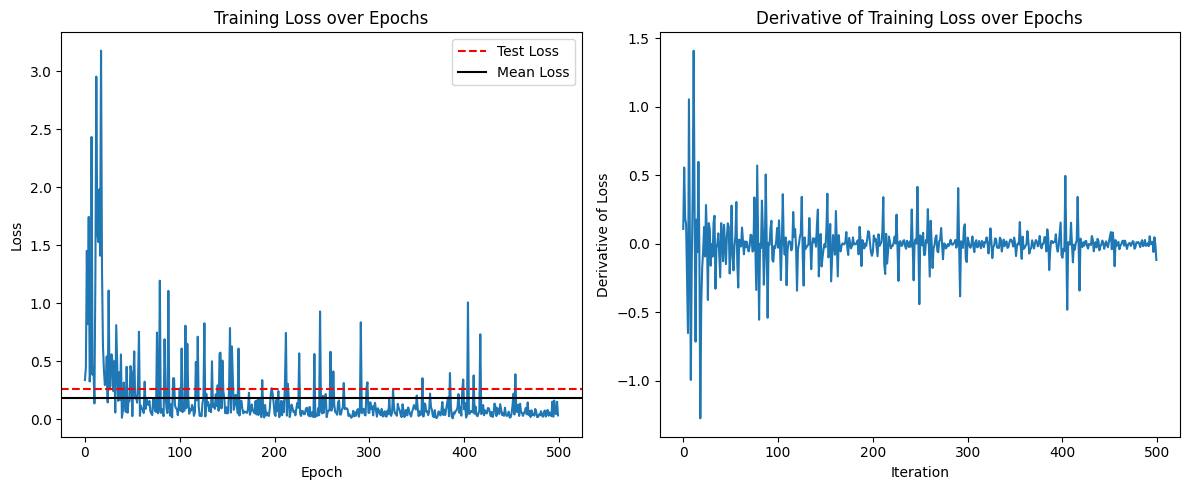

In [10]:
import matplotlib.pyplot as plt
import numpy as np

reduced_losses = (np.array(losses)).reshape(-1, 2).mean(axis=1)
log_mean_loss = np.array(losses).mean()

diff = abs(log_mean_loss - loss)

log_mean_loss = (log_mean_loss)
log_test_loss = (loss)

print(f"Difference between the mean loss and the test loss: {diff:.4f}")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the reduced losses
axs[0].plot(reduced_losses)

axs[0].axhline(y=log_test_loss, color='r', linestyle='--', label='Test Loss')
axs[0].axhline(y=log_mean_loss, color='black', linestyle='-', label='Mean Loss')

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].legend()

# Compute the derivative of reduced_losses
derivative_losses = np.gradient(reduced_losses)

axs[1].plot(derivative_losses)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Derivative of Loss')
axs[1].set_title('Derivative of Training Loss over Epochs')


plt.tight_layout()


In [11]:
torch.save(model.state_dict(), '../src/regression_model.pth')
print("Model saved to regression_model.pth")

Model saved to regression_model.pth
